<a href="https://colab.research.google.com/github/zw2497/RNN/blob/master/Phoneme_recognition_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phoneme recognition with neural networks using LSTM

In this Tutorial, we are going to get hands-on experience on how to use neural networks for acoustic modeling. We will use [TIMIT](https://catalog.ldc.upenn.edu/LDC93S1), a well-known audio corpus that has been used in this community for more than 20 years, for the task of phoneme recognition.

As you have learnt in the course, a phoneme is a basic unit of sound which distinguishs one word from another. Typically phonemes are written between slashes, such as /$\theta$/, /$p$/ and /d/. There are different ways to write them in different languages, and even in the same language the writing can vary from place to place. There are 61 phonemes defined in TIMIT, and the detailed explanation of them can be found in their [official documentation](https://catalog.ldc.upenn.edu/docs/LDC93S1/PHONCODE.TXT).

The target of phoneme recognition is to assign a phoneme label for each short segment or frame of the audio. The general task of mapping an audio clip to a sequence of phonemes is sometimes called ***acoustic modeling***. This task is typically formulated as a classification task, and in the case of TIMIT it is equivalent to a 61-way classification problem.

Prior to deep learning, a standard way to do phoneme recognition is to build a supervised GMM model on all the frames collected in the training data to maximize the posterior probability of the frames with their correct phoneme label. With deep learning, we can use neural networks to replace GMM, and typically it will lead to better performance. In this homework you will implement two models, a multilayer perceptron (MLP) and a long-short term memory network (LSTM). You can take a look at the tutorial notebook on Pytorch for deep learning if you are not familiar with how to implement them.

The backbone for the entire experiment will be provided in this notebook. You need to fill in the parts given the instructions. You can use any deep learning platform that you are comfortable with.

## 1. Dataset loading

We've already generated the features for you, so you don't need to worry about it. Please download them and put them in the same directory as this notebook (or wherever you want). Since the entire TIMIT dataset might be too large for you to run if you don't have a GPU, here we provide a subset of it which contains 462 sentences for training, 138 sentences for validation, and 92 sentences for evaluation. All sentences are truncated or zero-padded to 2 second long with 16kHz sample rate.

The time-frequency representation we use as the input feature is the log-power spectrogram calculated with a 1024-point, 512-hop size STFT. For each sentence, it gives you the feature of size (513, 65), where 513 is the frequency dimension and 65 is the number of frames.

All the datasets are already normalized based on the mean and standard deviation of the training set, so you don't need to make and further processing on them.

Each of the dataset has two entries: the *'spec'* entry contains the normalized log-power spectrograms for all the sentences, and the *'phoneme'* entry contains the one-hot vectors. We'll explain what does 'one-hot' means in a minute.

In [0]:
!wget https://github.com/zw2497/RNN/releases/download/v0.01/HW3-data.zip

In [0]:
import zipfile
local_zip = '/content/HW3-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [0]:
# load the datasets
import numpy as np
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

base_dir = "/tmp/data/"

tr_dataset = h5py.File( base_dir + 'tr', 'r')
cv_dataset = h5py.File( base_dir + 'cv', 'r')
tt_dataset = h5py.File( base_dir + 'tt', 'r')

(462, 513, 65)


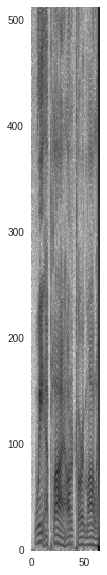

In [0]:
# the spectrograms
tr_spec = tr_dataset['spec']
print(tr_spec.shape)  # (num_data, freq_dim, num_frame)
plt.figure(figsize=(20, 10))
plt.imshow(tr_spec[10], origin='lower')
plt.grid(False)
plt.show()

A [one-hot](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) vector means that only one entry in the vector is non-zero, and its value is 1. For example, vector [0,0,0,1] is a one-hot vector, and [1,0] is also a one-hot vector. Typically people use it to encode categorical data when they want to do classification. For example, with a binary-classification problem with label 'dog' and 'cat', you can encode the labels into 2-dimensional vectors [1,0] or [0,1]. When the label is dog, you assign [1,0] to it, meaning that the first dimension of the vector is non-zero; when the label is cat, you assign [0,1]. You can do the same for a N-way classification problem with N labels, in the way that if the *i-th* label is the correct label for a data point, its one-hot label vector should be a N-dimensional vector with its *i-th* entry equals to one.

To describe it in a slightly more mathematical way, a binary vector $L\in \{0, 1\}^{N}$ is a one-hot vector when $\Sigma_N L = 1$, and the corresponding label index is $argmax(L)$.

Since there are 61 phonemes defined in TIMIT, the label of each frame in the dataset is represented by a 61-dimensional one-hot vector:

In [0]:
tr_phoneme = tr_dataset['phoneme']
print(tr_phoneme.shape)  # (num_data, num_frame, num_phoneme)
print(tr_phoneme[0,0])  # a sample of one-hot phoneme vector
print(np.argmax(tr_phoneme[0,:,:], 1))  # the phoneme labels for each frame in the phoneme list

(462, 65, 61)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0  0  0  0  0 24 24  2  2  2 39 39 29 29  2  2  2 25 25 53 53 53 53 15
 15  7  7  8 10 10 31 31 31 31 31 12 12 12 12 12 12 12 12 12 12 12 12  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


For your information, you can find the entire phoneme list in the *phoneme_list.npy* file we provided.

In [0]:
phoneme_list = np.load(base_dir + 'phoneme_list.npy')
print("All phonemes:", phoneme_list)

# an example phoneme sequence for a sentence
phoneme_index = np.argmax(tr_phoneme[0,:,:], 1)
prev_phoneme = ''
print('An Example phoneme sequence:', end=" ")
for index in phoneme_index:
    current_phoneme = phoneme_list[index]
    if current_phoneme != prev_phoneme:
        print(current_phoneme, end=" ")
    prev_phoneme = current_phoneme

All phonemes: ['h#' 'sh' 'iy' 'hv' 'ae' 'zh' 'ax-h' 'dcl' 'd' 'aa' 'r' 'kcl' 's' 'ux'
 'dx' 'ix' 'n' 'gcl' 'g' 'w' 'epi' 'uh' 'axr' 'ao' 'l' 'y' 'ih' 'ow' 'nx'
 'm' 'k' 'eh' 'oy' 'ay' 'dh' 'tcl' 'bcl' 'b' 'ah' 'v' 't' 'ch' 'q' 'en'
 'z' 'f' 'ey' 'ax' 'pcl' 'p' 'hh' 'jh' 'ng' 'er' 'th' 'em' 'aw' 'el' 'pau'
 'uw' 'eng']
An Example phoneme sequence: h# l iy v m iy y er ix dcl d r eh s h# 

Create your data loading functions for the three datasets above. Use the training set for training and the validation set for selecting the best model during training. After you finished training and selected the best performance model on the validation set, test your model on the test set.

Note that some of the sentences were zero-padded at the end to 2 seconds when generating the dataset to make sure all sentences have the same length, and there's no phoneme label for the zero-padded frames. It will run into trouble when we design the training objective function later, and we will talk about it in the later cells. Here when you write your data loading functions, make sure to also load the length of each sentence:

In [0]:
# length (number of non-zero-padded frames) for each sentence
actual_num_frame = tr_dataset['length']
print(actual_num_frame[:10])  # number of valid frames for each log-power spectrogram

[47 63 63 63 63 63 63 63 63 58]


In [0]:
tr_spec = np.array(tr_dataset['spec'])
tr_phoneme = np.array(tr_dataset['phoneme'])
tr_length = tr_dataset['length']
train_x = np.array(tr_spec).astype('float32')
train_x = np.swapaxes(train_x,1,2)
train_y = np.array(tr_phoneme).astype('float32')
train_l = np.array(tr_length).reshape(train_x.shape[0],1).astype('float32')
# train_x = train_x.reshape(train_x.shape[0] * train_x.shape[1], train_x.shape[2])
# train_y = train_y.reshape(train_y.shape[0] * train_y.shape[1], train_y.shape[2])

cv_spec = np.array(cv_dataset['spec'])
cv_phoneme = np.array(cv_dataset['phoneme'])
cv_length = cv_dataset['length']
val_x = np.array(cv_spec).astype('float32')
val_x = np.swapaxes(val_x,1,2).astype('float32')
val_y = np.array(cv_phoneme).astype('float32')
val_l = np.array(cv_length).reshape(val_x.shape[0],1).astype('float32')
# val_x = val_x.reshape(val_x.shape[0] * val_x.shape[1], val_x.shape[2])
# val_y = np.array(cv_phoneme).reshape(138 * 65, 61)

tt_spec = np.array(tt_dataset['spec'])
tt_phoneme = np.array(tt_dataset['phoneme'])
tt_length = tt_dataset['length']
test_x = np.array(tt_spec).astype('float32')
test_x = np.swapaxes(test_x,1,2).astype('float32')
test_y = np.array(tt_phoneme).astype('float32')
test_l = np.array(tt_length).reshape(test_x.shape[0],1).astype('float32')
# test_x = test_x.reshape(test_x.shape[0] * test_x.shape[1], test_x.shape[2])
# test_y = np.array(tt_phoneme).reshape(92 * 65, 61)

print(train_x.shape)
print(train_y.shape)
print(train_l.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(462, 65, 513)
(462, 65, 61)
(462, 1)
(138, 65, 513)
(138, 65, 61)
(92, 65, 513)
(92, 65, 61)


In [0]:
!pip install tf-nightly-gpu-2.0-preview

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
import time

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y, train_l)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y, val_l)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y, test_l)).batch(batch_size)

In [0]:
train_dataset

<BatchDataset shapes: ((None, 65, 513), (None, 65, 61), (None, 1)), types: (tf.float32, tf.float32, tf.float32)>

Next we define the hyperparameters of the experiment. Following the procedure in the tutorial, we also use argparse to build a parser to store the hyperparameters. Feel free to change the values below according to your model configurations!

Then you can start build your model. First please implement a 3-layer MLP with 128 hidden units in each layer. You also need to define the optimizer of your model. If you want, you can also have learning rate scheduler to dynamically adjust your learning rate during training.

The typical nonlinear function for the output layer for classification tasks is the [Softmax function](https://en.wikipedia.org/wiki/Softmax_function). *Softmax* is a smoothed approximation of the *argmax* function that allows you to calculate the gradient and perform back-propagation. Softmax returns a probability distribution, so if it returns a K-dimensional vector $x\in \mathbb{R}^K$, it satisfies $\sum_{i=1}^K x_i = 1$ and $x_i > 0$. An example output for a 2-way classification task with *Softmax* as output nonlinear function could be [0.2, 0.8], [0.33, 0.67] or [0.91, 0.09].

In [0]:
# TODO: build a MLP. The output layer uses Softmax as the nonlinear function
def MyModel():
    model = tf.keras.Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(61, activation='softmax'))
    return model

To evaluate how close is your *Softmax* output to the actual one-hot label vector, you need a measurement function. The typical objective function in classification tasks is the [binary-cross entropy function (BCE)](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). When the output from *Softmax*, also noted as the ***predicted probability distribution*** of the labels, is close to the actual one-hot label vector, the BCE value should be close to zero. So the target will be to minimize the BCE function. The general formular for BCE is:

$BCE = \frac{1}{N} \sum_{i=1}^N - (y_i\times log(x_i) + (1-y_i)\times log(1-x_i))$

where $y\in \{0, 1\}^N$ is the N-dimensional one-hot label vector, and $x\in \mathbb{R}^N$ is the output from Softmax function. $N$ is the number of labels, and here $N=61$ since we have 61 phoneme types.

If you are not familiar with Softmax, BCE or the general classification problem with DL, you can check the [Pytorch function for Softmax](https://pytorch.org/docs/stable/nn.html?highlight=softmax#torch.nn.Softmax), [BCE](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss), and a [video tutorial for Softmax classification in Pytorch](https://www.youtube.com/watch?v=lvNdl7yg4Pg). You can also find many other online tutorials about this.

Note that we previously mentioned that some of the sentences were zero-padded, and there's no valid phoneme label for those frames. In the dataset the labels for those zero-padded frames were zero vectors instead of one-hot vectors, and it will run into trouble when we applly BCE loss on them. In order to discard those frames when calculating the objective function, we use a ***binary masking vector*** to mask out those frames. A binary masking vector is a vector whose first K elements are 1 and all the rest elements are 0. When multiplying it with another vector $p$, only the first K values in $p$ is preserved. Here we use it to 'mask out' the zero-padded frames, so they won't be considered in the objective function as well as backpropagation. Here is an example in Numpy:

Now it's your turn to implement it in your deep learning platform.

In [0]:
# implement the cross-entropy objective function
def cross_loss(logits, label, length):
    
    batch_size = logits.shape[0]

    actual_frame = tf.constant(length)  # B,
    binary_mask = np.zeros((batch_size, label.shape[1]))  # B, T
    
    for i in range(batch_size):
        binary_mask[i,:actual_frame[i]] = 1.

    # see how many non-zero entries are there

    # calculate BCE between output probability distribution and label
    bce_loss = - (label * tf.math.log(logits) + (1. - label) * tf.math.log(1. - logits))  # B, T, 61
    bce_loss = tf.reduce_mean(bce_loss, 2)  # B, T

    # multiple the binary mask with bce loss to mask out the last few zero-padded frames
    masked_bce_loss = binary_mask * bce_loss  # B, T

    # calculate the mean of it for back-propagation, only consider the valid frames
    average_masked_bce = tf.reduce_sum(masked_bce_loss, 1) / actual_frame  # B
    average_masked_bce = tf.reduce_mean(average_masked_bce)
    return average_masked_bce

# build the model optimizer with Adam, SGD, RMSProp, etc.
optimizer = tf.keras.optimizers.Adam()

Note that BCE only gives you a value, but cannot tell you how many frames have been correctly categorized. To measure the classification accuracy, you also need to define another function to cound the total number of frames that has been correctly labeled. Here is an example in Numpy:

Here the operations are done in Numpy, so you either need to transform your Pytorch/Keras/Tensorflow data into Numpy format, or to implement them in the platform you select. Also make sure you are calculating the total number of correct frames across all the batches, since you will perform batch training.

In [0]:
# implement the function for classification accuracy
def calc_accuracy(logits, labels):
    # the label index for the predicted output probability
    logits = logits.numpy().reshape(logits.shape[0] * logits.shape[1], logits.shape[2])
    labels = labels.reshape(labels.shape[0] * labels.shape[1], labels.shape[2])

    predicted_label_index = np.argmax(logits, axis=1)
    target_label_index = np.argmax(labels, axis=1)
    correct_frame = np.sum(tf.equal(predicted_label_index, target_label_index))
    return correct_frame * 100. / logits.shape[0]

In [0]:
calc_accuracy(model(train_x), train_y)

48.07525807525808

Next you need to define the functions for training and validation. You can follow my pipeline in the Pytorch tutorial, or you can also use your own template. 

When selecting the best performance model in the validation set, you can either use BCE value or the classification accuracy as the indicator. I would recommend you to use BCE value for learning rate scheduling (if you have it), and classification accuracy for finding the best model.

In [0]:
# function for training
def train_step(train, label, length):
    with tf.GradientTape() as tape:
        logits = model(train, training=True)
        bce_loss = cross_loss(logits, label, length)

    gradient = tape.gradient(bce_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))


Finally you can start the training and validation. Save the best model you find.

In [0]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
        for (batch, (train_65_513, label_65_61, length_1)) in enumerate(train_dataset):
            train_step(train_65_513, label_65_61, length_1)
            
        acc_tr = calc_accuracy(model(train_x), train_y)
        acc_cv = calc_accuracy(model(val_x), val_y)
        print('Train accuracy %.2f' % acc_tr)
        print('Test accuracy %.2f' % acc_cv)
        print ('Time for epoch {} is {} sec \n'.format(epoch + 1, time.time()-start))

In [0]:
%%time
acc = []
val_acc = []
model = MyModel()
epochs = 20
train(train_dataset, epochs)

Train accuracy 23.79
Test accuracy 24.65
Time for epoch 1 is 0.8391127586364746 sec 

Train accuracy 26.97
Test accuracy 27.66
Time for epoch 2 is 0.7744810581207275 sec 

Train accuracy 29.10
Test accuracy 29.74
Time for epoch 3 is 0.7668559551239014 sec 

Train accuracy 30.84
Test accuracy 31.13
Time for epoch 4 is 0.7251977920532227 sec 

Train accuracy 32.26
Test accuracy 32.11
Time for epoch 5 is 0.7201511859893799 sec 

Train accuracy 33.50
Test accuracy 32.64
Time for epoch 6 is 0.7141437530517578 sec 

Train accuracy 34.46
Test accuracy 33.37
Time for epoch 7 is 0.7188770771026611 sec 

Train accuracy 35.39
Test accuracy 33.78
Time for epoch 8 is 0.728510856628418 sec 

Train accuracy 36.09
Test accuracy 34.08
Time for epoch 9 is 0.7141680717468262 sec 

Train accuracy 36.83
Test accuracy 34.54
Time for epoch 10 is 0.7249984741210938 sec 

Train accuracy 37.58
Test accuracy 34.84
Time for epoch 11 is 0.7314774990081787 sec 

Train accuracy 38.08
Test accuracy 35.33
Time for epo

And by the end you need to evaluate your model in the test set. The procedure is exactly the same as what you do in the validation set, so you can actually simply call the function you write for validation on the test set. Print the classification accuracy.

In [0]:
# test your model on the test set
acc_tt = calc_accuracy(model(test_x), test_y)
print(acc_tt)

35.03344481605351


Next you will need to implement a one-layer LSTM network with 128 hidden units on the same task. You can also follow the pipeline in the tutorial for the implementation.

In [0]:
# a 1-layer LSTM network with a FC layer for Softmax output
def MyModelLSTM():
    model = tf.keras.Sequential()   
    model.add(LSTM(128, activation='tanh', return_sequences= True))
    model.add(Dense(61, activation='softmax'))
    return model

# define optimizer
optimizer = tf.keras.optimizers.Adam()
# The objective function should be the same, just to be careful about the shape of the output in the two models

And then do the same training/validation/testing. You don't need to re-implement those functions, just use the ones you defined above with this model. Print the classification accuracy.

In [0]:
model = MyModelLSTM()
model(train_x).shape

W0303 02:57:18.300682 140068014978944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f63a004e828>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


TensorShape([462, 65, 61])

In [0]:
%%time
acc = []
val_acc = []
model = MyModelLSTM()
epochs = 25
train(train_dataset, epochs)

W0303 03:02:24.448110 140068014978944 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f6376f71c88>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Train accuracy 29.38
Test accuracy 28.80
Time for epoch 1 is 1.0738818645477295 sec 

Train accuracy 35.88
Test accuracy 34.34
Time for epoch 2 is 1.0332038402557373 sec 

Train accuracy 41.08
Test accuracy 37.87
Time for epoch 3 is 1.0351083278656006 sec 

Train accuracy 44.24
Test accuracy 39.60
Time for epoch 4 is 1.0242724418640137 sec 

Train accuracy 47.98
Test accuracy 40.97
Time for epoch 5 is 1.0319719314575195 sec 

Train accuracy 50.52
Test accuracy 41.52
Time for epoch 6 is 1.0397872924804688 sec 

Train accuracy 53.69
Test accuracy 42.26
Time for epoch 7 is 1.0198259353637695 sec 

Train accuracy 56.05
Test accuracy 42.64
Time for epoch 8 is 1.0291836261749268 sec 

Train accuracy 58.33
Test accuracy 43.17
Time for epoch 9 is 1.0430152416229248 sec 

Train accuracy 60.49
Test accuracy 43.24
Time for epoch 10 is 1.035017967224121 sec 

Train accuracy 62.55
Test accuracy 43.40
Time for epoch 11 is 1.027392864227295 sec 

Train accuracy 64.34
Test accuracy 43.58
Time for epoc

In [0]:
# TODO: test your model on the test set
acc_tt = calc_accuracy(model(test_x), test_y)
print(acc_tt)

42.290969899665555
